In [127]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.rcParams.update({'font.size': 22, 'grid.linestyle': '-', 'grid.color': 'gray' })


In [128]:
# dataset_merge_file = "../data/output/dataset_merge.tsv"
dataset_merge_file = "../data/output/dataset.tsv"

references_dir = "../data/output/references"

# Output
fig_dir = "../data/output"

In [135]:
tuples = []
for reference_file in os.listdir(references_dir):
    with open("{}/{}".format(references_dir, reference_file)) as f:
        data = {}
        reference_name = reference_file.split(".")[0]
        group = None
        for k in ['linker', 'binding', 'disorder']:  # order matters
            if k in reference_name:
                group = k
                break
        for line in f:
            if line:
                if line[0] == ">":
                    name = line.strip()[1:]
                    data.setdefault(name, [])
                else:
                    data[name].append(list(line.strip()))
        for name in data:
            for i, (aa, val) in enumerate(zip(*data[name])):
                tuples.append((group, reference_name, name, i + 1, aa, val))
df = pd.DataFrame(tuples, columns=['group', 'reference', 'disprot_id', 'pos', 'aa', 'value'])
df.set_index(['group', 'reference', 'disprot_id', 'pos', 'aa'], inplace=True)
df

value
group    reference       disprot_id pos aa      
linker   linker_disorder DP02418    1   M      -
                                    2   A      -
                                    3   S      -
                                    4   P      -
                                    5   P      -
...                                          ...
disorder disorder_nox    DP03906    178 G      1
                                    179 V      1
                                    180 T      1
                                    181 I      1
                                    182 K      1

[1591398 rows x 1 columns]

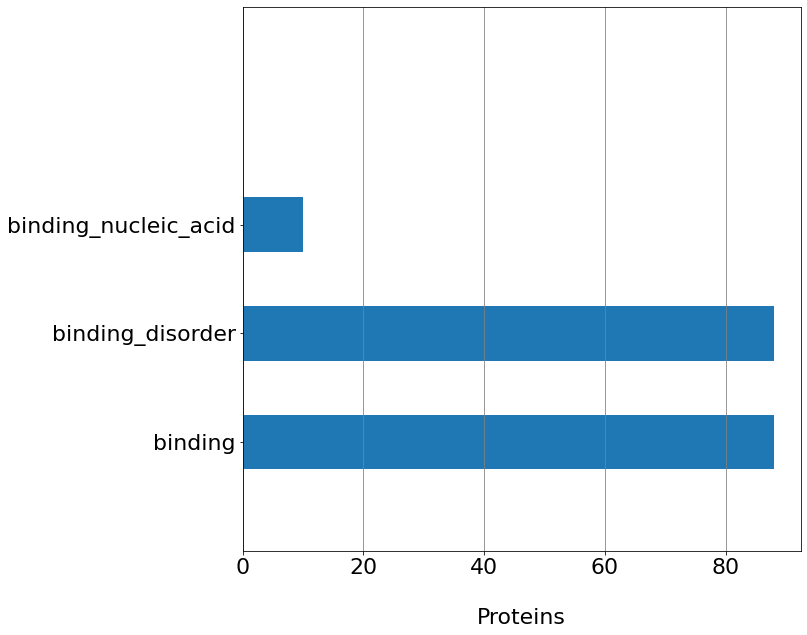

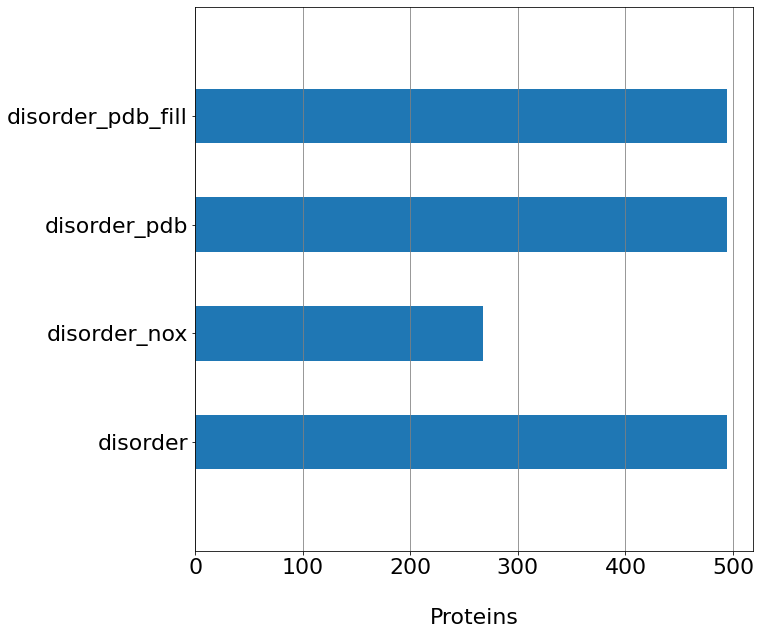

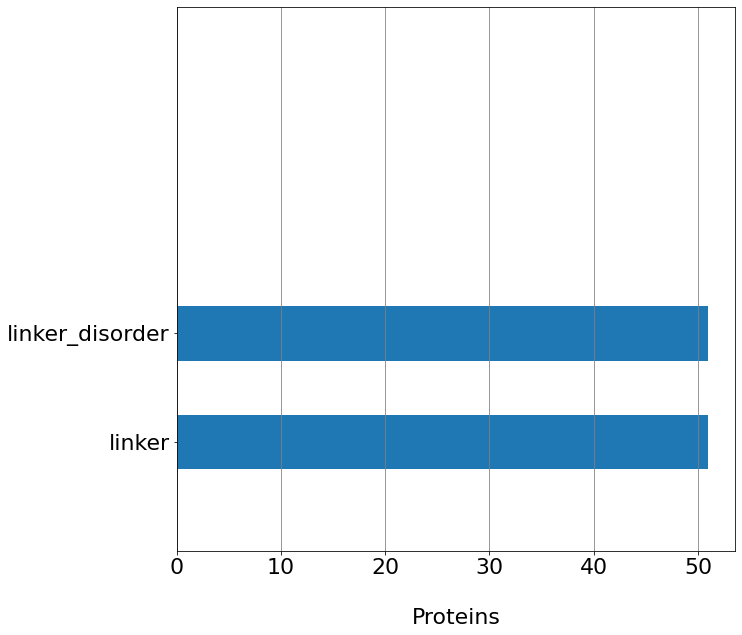

In [130]:
for group, df_g in df.groupby(level='group'):
    df2 = df_g.reset_index(level='disprot_id').groupby(['reference'])['disprot_id'].nunique().reset_index().set_index('reference')
    # print(df2)

    fig, ax = plt.subplots(figsize=(10, 10))
    df2.plot(kind='barh', width=0.5, ax=ax)
    ax.xaxis.grid()
    ax.set_ybound(-1, 4)
    ax.get_legend().remove()
    ax.set_xlabel('Proteins', labelpad=30)

    fig.gca().set_ylabel("")
    fig.savefig("{}/stat_proteins_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

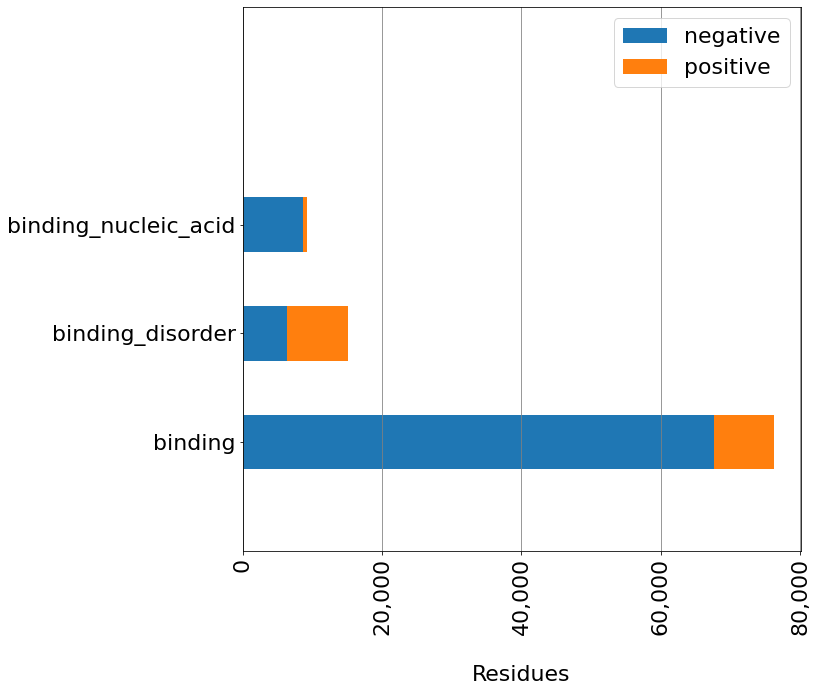

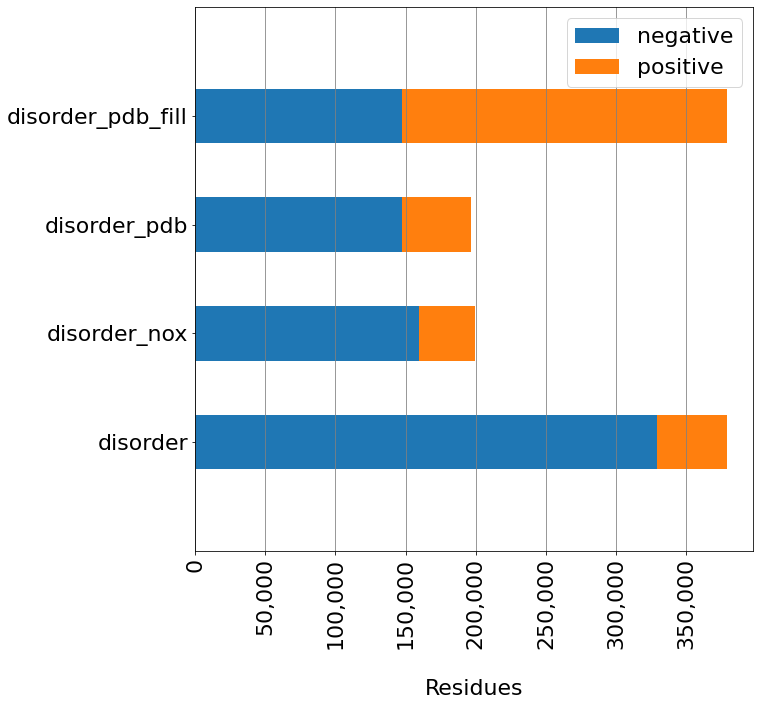

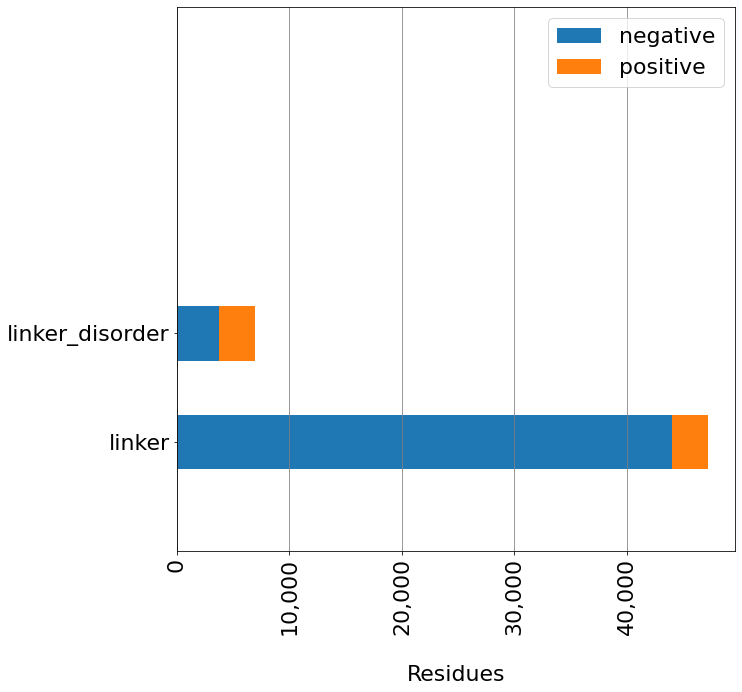

In [131]:
# TODO print the ratio (%) on top of the bars
for group, df_g in df.groupby(level='group'):
    df2 = df_g.groupby(['reference'])['value'].value_counts().unstack('value').fillna(0).sort_values(by=['reference'], ascending=[True]).drop(columns=['-'])
    # print(df2)

    fig, ax = plt.subplots(figsize=(10, 10))
    df2.plot(kind='barh', stacked=True, ax=ax)
    ax.xaxis.grid()
    ax.set_ybound(-1, 4)
    ax.set_xlabel('Residues', labelpad=30)
    ax.xaxis.set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.tick_params(axis='x', labelrotation=90)

    ax.legend(['negative', 'positive'])

    fig.gca().set_ylabel("")
    fig.savefig("{}/stat_residues_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')

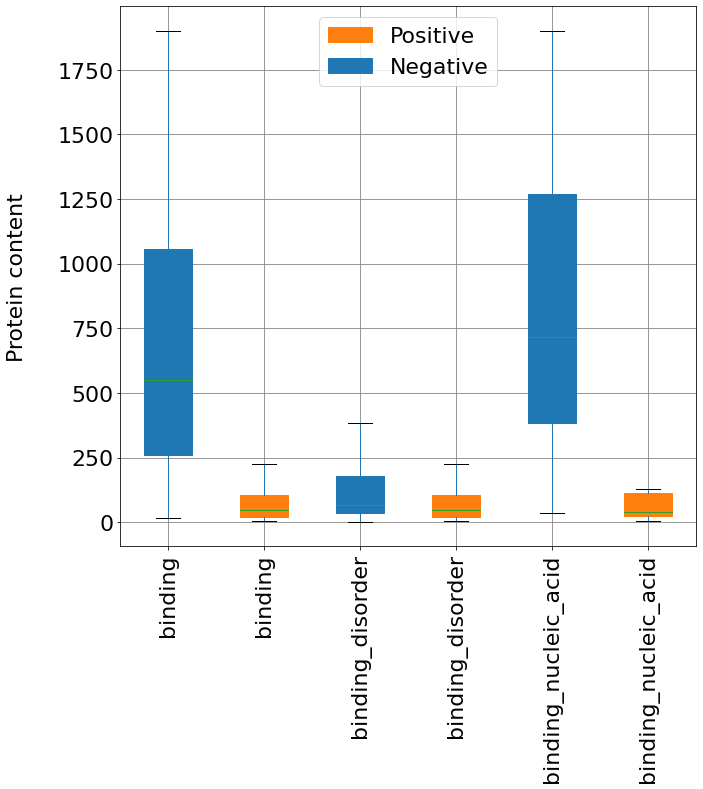

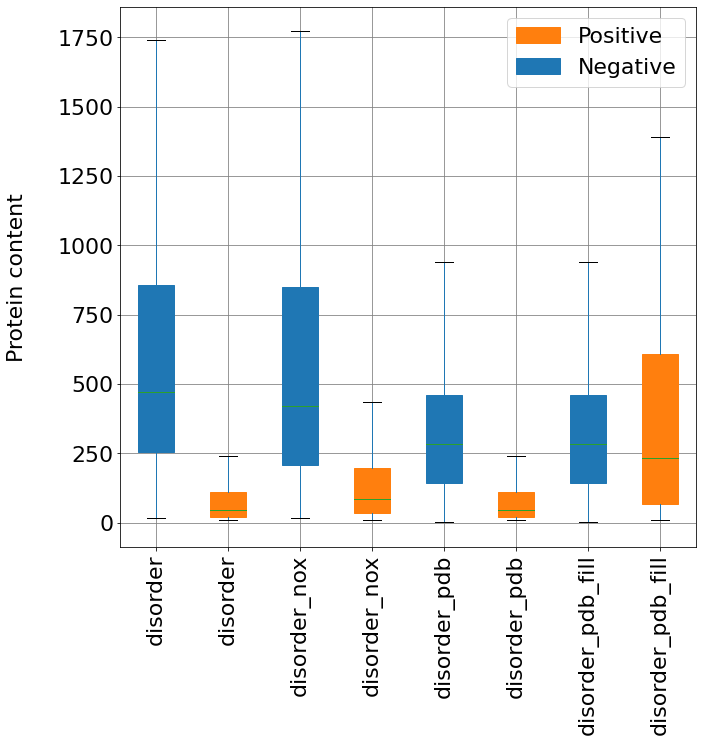

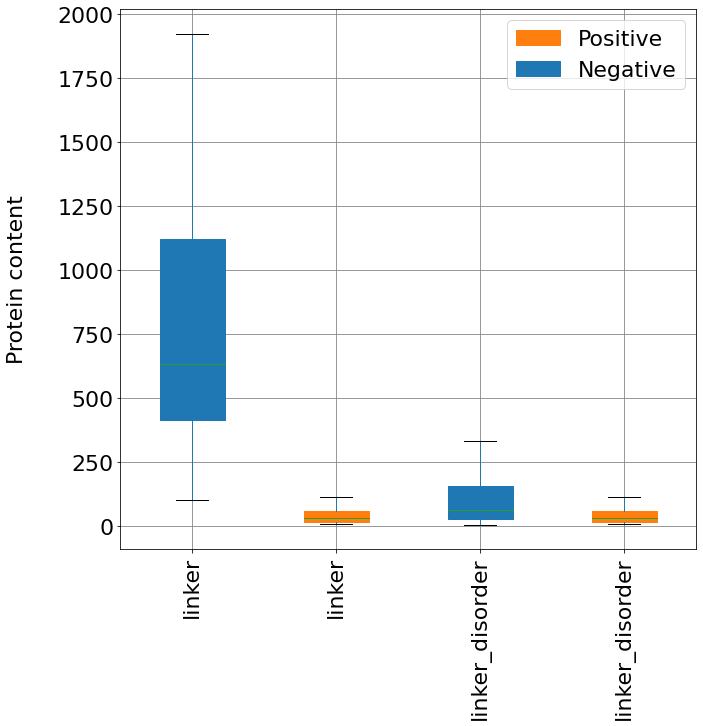

In [132]:
# Content at the protein level
for group, df_g in df.reset_index().groupby('group'):
    df_len = df_g.groupby(['disprot_id', 'reference', 'value']).agg({'pos': 'count'}).droplevel('disprot_id').reset_index()
    df_len = df_len.loc[df_len['value'] != '-']
    # print(df_len)

    fig, ax = plt.subplots(figsize=(10, 10))
    bp = df_len.boxplot(by=['reference', 'value'], ax=ax, showfliers=False, return_type='dict', patch_artist=True)
    ax.tick_params(axis='x', labelrotation=90)
    # fill with colors
    colors = {'0': '#1f77b4', '1': '#ff7f0e'}
    for patch, (label, df_g) in zip(bp['pos']['boxes'], df_len.groupby(['reference', 'value'])):
        patch.set_color(colors[label[1]])

    ax.set_ylabel('Protein content', labelpad=30)

    positive = mpatches.Patch(label='Positive', color=colors['1'])
    negative = mpatches.Patch(label='Negative', color=colors['0'])
    ax.legend(handles=[positive, negative])

    labels = [item.get_text()[1:-1].split(",")[0] for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)


    plt.suptitle("")
    plt.title('')
    fig.gca().set_xlabel("")
    fig.savefig("{}/stat_content_{}.png".format(fig_dir, group), dpi=300, bbox_inches='tight')
    # break

In [133]:
# TODO
# statistics by detection method
# statistics of fully disordered proteins
# venn diagram proteins of the various references
# taxon distribution
# distribution of disorder content as %